In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [0]:
df = pd.read_csv('USvideos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


In [4]:
def count_unique(x):
  for col in x.columns:
    print(f'{col}: {x[col].nunique()}')

count_unique(df)

video_id: 6351
trending_date: 205
title: 6455
channel_title: 2207
category_id: 16
publish_time: 6269
tags: 6055
views: 40478
likes: 29850
dislikes: 8516
comment_count: 13773
thumbnail_link: 6352
comments_disabled: 2
ratings_disabled: 2
video_error_or_removed: 2
description: 6901


In [5]:
nsamples = df.shape[0]

# Remove error/removed videos
df = df.loc[df.video_error_or_removed == False, ]
print('Remained: ', f'{(df.shape[0]/nsamples)*100}', '% of the original dataset size')

# Remove rating disabled videos
df = df.loc[df.ratings_disabled == False, ]
print('Remained: ', f'{(df.shape[0]/nsamples)*100}', '% of the original dataset size')

# Remove comment disabled videos
df = df.loc[df.comments_disabled == False, ]
print('Remained: ', f'{(df.shape[0]/nsamples)*100}', '% of the original dataset size')


Remained:  99.94383257222398 % of the original dataset size
Remained:  99.53112408117414 % of the original dataset size
Remained:  98.24415736648025 % of the original dataset size


In [6]:
# Columns not considered in preliminar model 
# dependent of NLP implementation or of low correlation with target

drop_col = [ 'tags', 'description', 'video_error_or_removed', 'ratings_disabled', 'comments_disabled', 'thumbnail_link']
df.drop(columns=drop_col, inplace=True)

df.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'views', 'likes', 'dislikes', 'comment_count'],
      dtype='object')

In [0]:
df.trending_date = pd.to_datetime(df.trending_date, format='%y.%d.%m')

In [8]:
# Example of top 10 liked videos in Nov 2017

df_2017 = df[df.trending_date.dt.year == 2017]
var = 'views'
mon = 11 #11-12

df_2017.loc[df.trending_date.dt.month == mon, ['video_id', 'title', var]].groupby(['video_id', 'title']).sum().sort_values(var, ascending = False).head(10)

,,views
video_id,title,
TyHvyGVs42U,"Luis Fonsi, Demi Lovato - Échame La Culpa",534738794
ZJDMWVZta3M,Incredibles 2 Official Teaser Trailer,215069746
kTlv5_Bs8aw,BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Official MV,151195373
2Vv-BfVoq4g,Ed Sheeran - Perfect (Official Music Video),116055498
EBt_88nxG4c,P!nk - Beautiful Trauma (Official Video),116054176
n1WpP7iowLc,Eminem - Walk On Water (Audio) ft. Beyoncé,111426920
cH4E_t3m3xM,"Selena Gomez, Marshmello - Wolves",105280619
8-Cjsnq8kVU,Deadpool’s “Wet on Wet” Teaser,75091844
_EvMYEfF_hQ,Stranger Things Cast Answer the Web's Most Searched Questions | WIRED,74021271


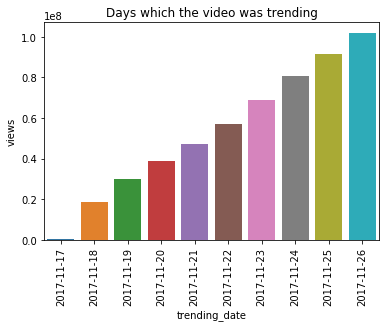

In [9]:
# Verify how many days the video was trending
# Example: id:'TyHvyGVs42U' - title: 'Luis Fonsi, Demi Lovato - Échame La Culpa'

temp = df.loc[df.video_id == 'TyHvyGVs42U', ['views', 'trending_date'] ]
temp.trending_date = temp.trending_date.apply(lambda x: x.date())

_ = sns.barplot(x='trending_date', y='views', data=temp )
plt.xticks(rotation=90)
plt.title('Days which the video was trending')
plt.show()

In [0]:
# Create column of video publication hour
df.publish_time = pd.to_datetime(df.publish_time, format='%Y-%m-%d')
df['publish_hour'] = df.publish_time.dt.hour

In [0]:
# Select top 100 channels and assign remainings to 'other' category 
# df2 = df.copy()
# df2.drop_duplicates('video_id', inplace=True)
# temp2 = df2.channel_title.value_counts().iloc[:100].index

# df.channel_categ = df.channel_title
# df.loc[[item not in temp2 for item in df.channel_title], 'channel_categ'] = 'other'


In [0]:
# df.channel_categ.value_counts()[:10]

In [0]:
# Selection of model features and 'views' as target

df.sort_values('views', ascending=False, inplace=True)
df.drop_duplicates('video_id', inplace=True) # select video record with highest view and delete remaining

df.drop(columns=['video_id', 'trending_date', 'title', 'channel_title', 'publish_time'] , inplace=True)

In [13]:
# Split in train and test dataset

X = df.drop(columns=['views']).copy()
y = df['views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4678, 5) (4678,)
(1560, 5) (1560,)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6238 entries, 38547 to 14782
Data columns (total 6 columns):
category_id      6238 non-null int64
views            6238 non-null int64
likes            6238 non-null int64
dislikes         6238 non-null int64
comment_count    6238 non-null int64
publish_hour     6238 non-null int64
dtypes: int64(6)
memory usage: 341.1 KB


In [0]:
# Encoder categorical features to numerical or one-hot

# encoder_channel = LabelEncoder()
# X_train.channel_categ = encoder_channel.fit_transform(X_train.channel_categ)

In [0]:
# Scale the feature ranges
scaler = StandardScaler().fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)


### Linear Regression


In [17]:
model = LinearRegression()
model.fit(X_train_scaler, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
pred = model.predict(X_test_scaler)

### Metrics

In [0]:
def r_metrics(m, X, y):
    yhat = m.predict(X)
    #print(yhat)
    SS_Residual = sum((y-yhat)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adj_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    return r_squared,adj_r_squared

In [20]:
MSE = mean_squared_error(y_test, pred)
MAE = mean_absolute_error(y_test, pred)
R2 = model.score(X_test_scaler, y_test)

print('MSE: ', MSE,'\nMAE: ',  MAE, '\nR2: ', R2)

MSE:  8648746828829.0205 
MAE:  1019365.200352887 
R2:  0.7169879561572972


In [0]:
res = pd.DataFrame({'true':y_test, 'pred':pred})
#res.head(20)

In [22]:
r2, adj_r2 = r_metrics(model, X_test_scaler, y_test)
print('R2: ', r2, '\nAdjusted R2: ', adj_r2)

R2:  0.7169879561572965 
Adjusted R2:  0.7160773639956404


### Cross Validating common regression models 

In [0]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [0]:
models = []

models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('RandomForest', RandomForestRegressor(n_estimators=50))) # 
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('SVR', SVR(gamma='auto')))

names = []

In [25]:
for name, model in models:
    kfold = KFold(n_splits=5, random_state=3)
    cv_results = cross_val_score(model, X_train_scaler, y_train, cv=kfold, scoring='r2')
    names.append(name)
    msg = "%s: %f" %(name, cv_results.mean())
    print(msg)
    

DecisionTree: 0.540559
RandomForest: 0.740880
GradientBoosting: 0.707178
SVR: -0.050668


In [26]:
model2 = RandomForestRegressor(n_estimators=50)
model2.fit(X_train_scaler, y_train)
pred = model2.predict(X_test_scaler)

R2 = model2.score(X_test_scaler, y_test)
MAE = mean_absolute_error(pred, y_test)
MSE = mean_squared_error(pred, y_test)

print('MSE: ', MSE, '\nMAE: ', MAE, '\nR2: ', R2 )


MSE:  4991414303592.267 
MAE:  775194.8354743589 
R2:  0.8366664683701224
